# Analysis of Brussels' Neighborhoods for a future residents

## 1. Introduction

The present project is an analysis of the neighborhoods of the city of Brussels and its surrounding municipalities (Brussels Capital Region), intended to cluster neighborhoods according to the availability of services and determining which neighborhoods best fit my personal interests.

As a resident of Brussels, I decided to use the geographical data of Brussels paired with queries from the Foursquare API to cluster the neighborhoods of Brussels, with the goal to create a tool to help possible residents when they look for accommodation in the city. This particular clustering of Brussels is going to be tailored according to my preferences and personal selection criteria, nonetheless, it serves as a good reference point to evaluate the different neighborhoods.

The Brussels Capital region is located at the center of Belgium, and it consists of 19 different municipalities, including the City of Brussels, which is the capital of Belgium. Because of its central location, the region forms part of both the French Community of Belgium, and the Flemish Community.


Since the end of the Second World War, Brussels has played an important role in international politics, becoming the capital of the European Union, and the headquarters of NATO. On a cultural note, Brussels is known for its gastronomy and its architectural landmarks, some of which are categorized as UNESCO World Heritage sites (e.g. La Grand Place, Manneken Pis, Atomium, etc.).

## 2. Methods and data

### 2.1 Libraries and packages

In order to pull information from the Foursquare API, it is first necessary to extract the geographical coordinates of the neighborhoods of Brussels. For this, we will have to use the Geocoder Python Package, which extracts the coordinates of a neighborhood/municipality based on the respective postal code. 

Now, to obtain the lists of postal codes and neighborhood names, I will scrape a table from the Wikipedia List of Brussels Municipalities: (https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region) using the BeautifulSoup web-scraping package. 

With these libraries, we will obtain a dataframe which we will pair with the information pulled from the Foursquare API, in order to obtain some descriptive measures of the availability of services in the neighborhoods, and then proceed to cluster them according to a K-Means algorithm. 

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### 2.2 Webpage scraping

Now we are going to take a look at the html of the Wikipedia page of List of Brussels' Neighborhoods. 

In [2]:
import urllib.request
import requests

# importing the necessary libraries to query information from Wikipedia

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region'

In [4]:
page = urllib.request.urlopen(url)

In [5]:
soup = BeautifulSoup(page, 'lxml')

The following is the html code of the Wikipedia page. Now, I am interested in one particular table, therefore I will look for table objects in the code using the .find_all method. 

In [6]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of municipalities of the Brussels-Capital Region - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"9d0349ab-8714-48a3-9831-7880a23ea5e9","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_municipalities_of_the_Brussels-Capital_Region","wgTitle":"List of municipalities of the Brussels-Capital Region","wgCurRevisionId":923747618,"wgRevisionId":923747618,"wgArticleId":261746,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles containing French-langu

In [7]:
soup.title.string

'List of municipalities of the Brussels-Capital Region - Wikipedia'

In [8]:
all_tables=soup.find_all("table")

In [9]:
all_tables

[<table class="vertical-navbox nowraplinks" style="float:right;clear:right;width:22.0em;margin:0 0 1.0em 1.0em;background:#f8f9fa;border:1px solid #aaa;padding:0.2em;border-spacing:0.4em 0;text-align:center;line-height:1.4em;font-size:88%;width: 15em"><tbody><tr><th style="padding:0.2em 0.4em 0.2em;font-size:145%;line-height:1.2em;font-size: 100%">Politics and government<br/>of Brussels</th></tr><tr><td style="padding:0.2em 0 0.4em"><a class="image" href="/wiki/File:Flag_of_the_Brussels-Capital_Region.svg" title="Emblem of the Brussels-Capital Region"><img alt="Emblem of the Brussels-Capital Region" data-file-height="600" data-file-width="900" decoding="async" height="83" src="//upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Flag_of_the_Brussels-Capital_Region.svg/125px-Flag_of_the_Brussels-Capital_Region.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Flag_of_the_Brussels-Capital_Region.svg/188px-Flag_of_the_Brussels-Capital_Region.svg.png 1.5x, //upload.wikime

We see above that the name of the desired table is 'Wikitable Sortable', so now we are going to isolate the target table. 

In [10]:
right_table = soup.find('table', class_ ='wikitable sortable')
right_table

<table class="wikitable sortable">
<tbody><tr>
<th>
</th>
<th>French name
</th>
<th>Dutch name
</th>
<th class="unsortable"><a href="/wiki/Flag" title="Flag">Flag</a>
</th>
<th class="unsortable"><a href="/wiki/Coat_of_arms" title="Coat of arms">CoA</a>
</th>
<th><a href="/wiki/Postal_code" title="Postal code">post<br/><small>code</small></a>
</th>
<th>Population<br/><small>(1/1/2017)</small>
</th>
<th>Area
</th>
<th><a href="/wiki/Population_density" title="Population density">Population density</a><br/><small>(km²)</small>
</th>
<th class="unsortable">Ref.
</th></tr>
<tr>
<td style="text-align:center;">1
</td>
<td style="text-align:left"><a href="/wiki/Anderlecht" title="Anderlecht">Anderlecht</a>
</td>
<td style="text-align:left"><a href="/wiki/Anderlecht" title="Anderlecht">Anderlecht</a>
</td>
<td style="text-align:center;"><a class="image" href="/wiki/File:Flag_of_Anderlecht.svg"><img alt="Flag of Anderlecht.svg" class="thumbborder" data-file-height="400" data-file-width="600" de

Now, it can be seen above that the table provides a lot of information which is not necessary for the analysis. We are only interested in one name for each municipality, as well as their respective postal code. Therefore, I am going to create lists to insert the observations from the table, and each list will contain the observation from each column. Afterwards, I am only going to include the target columns and their respective observations in a new dataframe.

In [11]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []
nine = []

for row in right_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) == 9:
        one.append(cells[0])
        two.append(cells[1])
        three.append(cells[2])
        four.append(cells[3])
        five.append(cells[4])
        six.append(cells[5])
        seven.append(cells[6])
        eight.append(cells[7])


In [12]:
import re 
CLEAN = re.compile('\s+')
two = [CLEAN.sub('', b.text).strip() for b in two]
six = [CLEAN.sub('', e.text).strip() for e in six]

# html code has a lot of elements that are not necessary for our analysis, therefore here I delete them



In [13]:
df = pd.DataFrame (two, columns =['Municipalities'])
df['Postal Codes'] = six
df

,Municipalities,Postal Codes
0,Anderlecht,1070
1,Auderghem,1160
2,Berchem-Sainte-Agathe,1082
3,Bruxelles-Ville*,1000102011201130
4,Etterbeek,1040
5,Evere,1140
6,Forest,1190
7,Ganshoren,1083
8,Ixelles,1050
9,Jette,1090


In [14]:
df['Postal Codes'][3] = 1000
df

,Municipalities,Postal Codes
0,Anderlecht,1070
1,Auderghem,1160
2,Berchem-Sainte-Agathe,1082
3,Bruxelles-Ville*,1000
4,Etterbeek,1040
5,Evere,1140
6,Forest,1190
7,Ganshoren,1083
8,Ixelles,1050
9,Jette,1090


Now that we have a dataframe with the municipalities and the respective postal codes, I will use the python geocoder package to pull the geographical coordinates per postal code, and then add it to our dataframe with the Municipalities and the Postal Codes.

It should be noted that the pgeocode package provides a lot of information that we do not require (e.g. Count Name, County Code, etc.), therefore I created a loop to include only the geographical coordinates of each municipality into a separate list.

In [15]:
import pgeocode
from pandas import DataFrame

geo_cords = []

for code in df['Postal Codes']:
    nomi = pgeocode.Nominatim('be')
    coords = nomi.query_postal_code(str(code))
    geo_cords.append((coords['latitude'], coords['longitude']))
    print(coords)

postal_code                                   1070
country code                                    BE
place_name                              Anderlecht
state_name                      Bruxelles-Capitale
state_code                                     BRU
county_name                Bruxelles (19 communes)
county_code                                    BRU
community_name    Arrondissement Brussel-Hoofdstad
community_code                                  21
latitude                                   50.8362
longitude                                   4.3145
accuracy                                         4
Name: 0, dtype: object
postal_code                                   1160
country code                                    BE
place_name                               Auderghem
state_name                      Bruxelles-Capitale
state_code                                     BRU
county_name                Bruxelles (19 communes)
county_code                                    BRU
communit

In [16]:
geo_cords
    

[(50.8362, 4.3145),
 (50.8167, 4.4333),
 (50.8657, 4.2956),
 (50.8504, 4.3488),
 (50.8327, 4.3884),
 (50.8744, 4.399),
 (50.8168, 4.3278),
 (50.8707, 4.3153),
 (50.8333, 4.3667),
 (50.8731, 4.3342),
 (50.8612, 4.3314),
 (50.8499, 4.3125),
 (50.8276, 4.3439),
 (50.8538, 4.3728),
 (50.8694, 4.3774),
 (50.8022, 4.3394),
 (50.8015, 4.4144),
 (50.8439, 4.4291),
 (50.8551, 4.3707)]

In [17]:
df1 = pd.DataFrame(list(geo_cords))
df1

# transforming the list with coordinates into a pandas dataframe

,0,1
0,50.8362,4.3145
1,50.8167,4.4333
2,50.8657,4.2956
3,50.8504,4.3488
4,50.8327,4.3884
5,50.8744,4.3990
6,50.8168,4.3278
7,50.8707,4.3153
8,50.8333,4.3667
9,50.8731,4.3342


In [18]:
df1['Latitude'] = df1[0]
df1['Longitude'] = df1[1]
df1

,0,1,Latitude,Longitude
0,50.8362,4.3145,50.8362,4.3145
1,50.8167,4.4333,50.8167,4.4333
2,50.8657,4.2956,50.8657,4.2956
3,50.8504,4.3488,50.8504,4.3488
4,50.8327,4.3884,50.8327,4.3884
5,50.8744,4.3990,50.8744,4.3990
6,50.8168,4.3278,50.8168,4.3278
7,50.8707,4.3153,50.8707,4.3153
8,50.8333,4.3667,50.8333,4.3667
9,50.8731,4.3342,50.8731,4.3342


In [19]:
del df1[0]
del df1[1]
df1

,Latitude,Longitude
0,50.8362,4.3145
1,50.8167,4.4333
2,50.8657,4.2956
3,50.8504,4.3488
4,50.8327,4.3884
5,50.8744,4.3990
6,50.8168,4.3278
7,50.8707,4.3153
8,50.8333,4.3667
9,50.8731,4.3342


In [20]:
df['Latitude'] = df1['Latitude']
df['Longitude'] = df1['Longitude']
df

,Municipalities,Postal Codes,Latitude,Longitude
0,Anderlecht,1070,50.8362,4.3145
1,Auderghem,1160,50.8167,4.4333
2,Berchem-Sainte-Agathe,1082,50.8657,4.2956
3,Bruxelles-Ville*,1000,50.8504,4.3488
4,Etterbeek,1040,50.8327,4.3884
5,Evere,1140,50.8744,4.3990
6,Forest,1190,50.8168,4.3278
7,Ganshoren,1083,50.8707,4.3153
8,Ixelles,1050,50.8333,4.3667
9,Jette,1090,50.8731,4.3342


Now that we got all we need to start creating a model, I am going to log in my user credentials for the Foursquare API and start pulling the data we need on bars, restaurants, etc. for each Municipality.

### 2.3 Pulling data from the Foursquare API

To use the Foursquare API to gather information about venues around you, it is first necessary to create a Developer Account, and from there you will get the credentials in order to download the data.

In [21]:
CLIENT_ID = 'DRAHHMU5EYFQQSIHMLS30YSMJBAID0OUEEMS3AB4ILW5OJDP' # your Foursquare ID
CLIENT_SECRET = 'QGR1QFHQDQ3B4JHAW2NNHNVZUBZEKUPRHDM2NXNKPYTB1YRM' # your Foursquare Secret
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DRAHHMU5EYFQQSIHMLS30YSMJBAID0OUEEMS3AB4ILW5OJDP
CLIENT_SECRET:QGR1QFHQDQ3B4JHAW2NNHNVZUBZEKUPRHDM2NXNKPYTB1YRM


Here I am going to display a folium map to display Brussels, with each municipality in the dataframe marked in blue.

In [22]:
address ='Brussels, Belgium'
geolocator = Nominatim(user_agent="battle-of-the-neighborhoods")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinates of Brussels are {}, {}'.format(latitude, longitude))

The geographical coordinates of Brussels are 50.8465573, 4.351697


In [23]:
map_bxl = folium.Map(location = [latitude, longitude], zoom_start=10)


In [24]:
for municipality, postalcode, lat, lng in zip(df['Municipalities'], df['Postal Codes'], df['Latitude'], df['Longitude']):
    label = '{}, {}'.format(municipality, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_bxl)
    
map_bxl

Here I will create a function to query the venue data from the Foursquare API.

In [25]:
LIMIT=50
## choose the maximum amount of venues per neighborhood you want to query

nearby_venues = []

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    

    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
bxl_venues = getNearbyVenues(names=df['Municipalities'], latitudes = df['Latitude'], longitudes = df['Longitude'])

Anderlecht
Auderghem
Berchem-Sainte-Agathe
Bruxelles-Ville*
Etterbeek
Evere
Forest
Ganshoren
Ixelles
Jette
Koekelberg
Molenbeek-Saint-Jean
Saint-Gilles
Saint-Josse-ten-Noode
Schaerbeek
Uccle
Watermael-Boitsfort
Woluwe-Saint-Lambert
Woluwe-Saint-Pierre


In [27]:
print(bxl_venues.shape)
bxl_venues

(567, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anderlecht,50.8362,4.3145,Friture René,50.835846,4.311632,Belgian Restaurant
1,Anderlecht,50.8362,4.3145,Le Chapeau Blanc,50.835034,4.307790,Restaurant
2,Anderlecht,50.8362,4.3145,Snack Mirvan,50.835176,4.308543,Snack Place
3,Anderlecht,50.8362,4.3145,Erasmushuis / Maison d'Erasme (Erasmushuis),50.836507,4.307860,History Museum
4,Anderlecht,50.8362,4.3145,Le Nil,50.836718,4.313628,Middle Eastern Restaurant
5,Anderlecht,50.8362,4.3145,Iberico,50.832146,4.311816,Gourmet Shop
6,Anderlecht,50.8362,4.3145,Proxy Delhaize,50.835256,4.310246,Grocery Store
7,Anderlecht,50.8362,4.3145,Carrefour Express,50.835387,4.310213,Convenience Store
8,Anderlecht,50.8362,4.3145,Panos,50.835544,4.310776,Sandwich Place
9,Anderlecht,50.8362,4.3145,Action,50.836618,4.315320,Discount Store


The function pulled a total of 567 venues. 

### 2.4 Descriptive statistics and exploratory analysis

Let's take a look at tthe number of venues per neighborhood.

In [28]:
bxl_venues_sum=bxl_venues.groupby('Neighborhood').count()
bxl_venues_sum


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Anderlecht,16,16,16,16,16,16
Auderghem,25,25,25,25,25,25
Berchem-Sainte-Agathe,17,17,17,17,17,17
Bruxelles-Ville*,50,50,50,50,50,50
Etterbeek,37,37,37,37,37,37
Evere,13,13,13,13,13,13
Forest,15,15,15,15,15,15
Ganshoren,30,30,30,30,30,30
Ixelles,48,48,48,48,48,48


In [29]:
del bxl_venues_sum['Neighborhood Latitude']
del bxl_venues_sum['Neighborhood Longitude']
del bxl_venues_sum['Venue Latitude']
del bxl_venues_sum['Venue Longitude']
del bxl_venues_sum['Venue Category']

bxl_venues_sum

,Venue
Neighborhood,
Anderlecht,16
Auderghem,25
Berchem-Sainte-Agathe,17
Bruxelles-Ville*,50
Etterbeek,37
Evere,13
Forest,15
Ganshoren,30
Ixelles,48


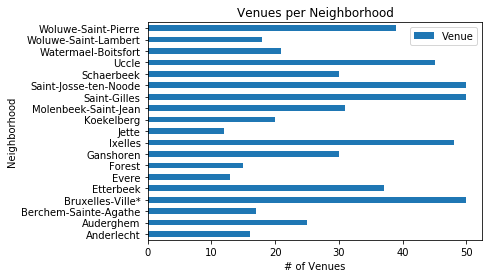

In [66]:
import matplotlib.pyplot as plt

bxl_venues_sum.plot(kind='barh')

plt.title('Venues per Neighborhood')
plt.xlabel('# of Venues')
plt.ylabel('Neighborhood')

plt.show()

Now, let's see how many unique categories of venues there are, and how common they are in all the neighborhoods. 

In [30]:
print('There are {} unique categories'.format(len(bxl_venues['Venue Category'].unique())))

There are 156 unique categories


In [32]:
bxl_venues_freqs = bxl_venues['Venue Category'].value_counts()

bxl_venues_freqs

Italian Restaurant                 28
Supermarket                        27
Plaza                              26
Bar                                26
Pizza Place                        21
Snack Place                        19
Sandwich Place                     14
Bakery                             14
Restaurant                         14
French Restaurant                  12
Convenience Store                  11
Park                               11
Turkish Restaurant                 10
Kebab Restaurant                    9
Thai Restaurant                     8
Brasserie                           8
Tram Station                        7
Cosmetics Shop                      7
Middle Eastern Restaurant           7
Hotel                               7
Greek Restaurant                    7
Burger Joint                        6
Portuguese Restaurant               6
Coffee Shop                         6
Concert Hall                        6
Gym                                 6
Belgian Rest

In [36]:
df2 = pd.DataFrame(bxl_venues_freqs)
df2

,Venue Category
Italian Restaurant,28
Supermarket,27
Plaza,26
Bar,26
Pizza Place,21
Snack Place,19
Sandwich Place,14
Bakery,14
Restaurant,14
French Restaurant,12


In [67]:
df2.head(10)

,Venue Count
Italian Restaurant,28
Supermarket,27
Plaza,26
Bar,26
Pizza Place,21
Snack Place,19
Sandwich Place,14
Bakery,14
Restaurant,14
French Restaurant,12


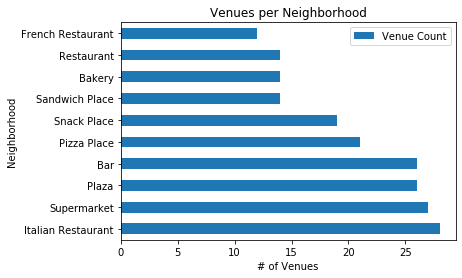

In [69]:
import matplotlib.pyplot as plt

df2.head(10).plot(kind='barh')

plt.title('Venues per Neighborhood')
plt.xlabel('# of Venues')
plt.ylabel('Neighborhood')

plt.show()

In [37]:
df2['Venue Count'] = df2['Venue Category']

df2

,Venue Category,Venue Count
Italian Restaurant,28,28
Supermarket,27,27
Plaza,26,26
Bar,26,26
Pizza Place,21,21
Snack Place,19,19
Sandwich Place,14,14
Bakery,14,14
Restaurant,14,14
French Restaurant,12,12


In [38]:
del df2['Venue Category']

In [39]:
df2

,Venue Count
Italian Restaurant,28
Supermarket,27
Plaza,26
Bar,26
Pizza Place,21
Snack Place,19
Sandwich Place,14
Bakery,14
Restaurant,14
French Restaurant,12


Now, I will dummy code each venue per neighborhood, in order to calculate the average relative frequency of the venue per neighborhood.

In [41]:
bxl_onehot = pd.get_dummies(bxl_venues[['Venue Category']], prefix ="", prefix_sep="")
## dummy coding each venue

bxl_onehot['Neighborhood'] = bxl_venues['Neighborhood']


fixed_columns = [bxl_onehot.columns[-1]] + list(bxl_onehot.columns[:-1])
bxl_onehot = bxl_onehot[fixed_columns]

bxl_onehot.head()

,Neighborhood,African Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Business Center,Café,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Venue,Office,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Photography Studio,Piano Bar,Piercing Parlor,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Resort,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shop & Service,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Winery,Yoga Studio
0,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
bxl_grouped = bxl_onehot.groupby('Neighborhood').mean().reset_index()
## grouping the dummy coded venues per neighborhood and calculating their mean occurrence

bxl_grouped

,Neighborhood,African Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Business Center,Café,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Venue,Office,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Photography Studio,Piano Bar,Piercing Parlor,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Resort,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shop & Service,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Winery,Yoga Studio
0,Anderlecht,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.062500,0.000000,0.00,0.00,0.062500,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.0625,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0625,0.062500,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.062500,0.00,0.062500,0.00,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00
1,Auderghem,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.040000,0.000000,0.04,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.00,0.0000,0.000000,0.00,0.000000,0.000000,0.00,0.080000,0.0

### 2.5 Neighborhood ranking

Now, this is the part that interests us in the analysis. Here, I will create a basic recommendation dataframe by determining my preferred venues on a scorecard and rating Brussels' neighborhoods as a function of how common the venues are in each neighborhood. 

Let's see the top 5 most common venues per neighborhood. 

In [43]:
num_top_venues = 5

for hood in bxl_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bxl_grouped[bxl_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anderlecht----
               venue  freq
0       Dance Studio  0.06
1      Metro Station  0.06
2         Restaurant  0.06
3  Convenience Store  0.06
4     Sandwich Place  0.06


----Auderghem----
                venue  freq
0  Italian Restaurant  0.12
1   French Restaurant  0.08
2    Sushi Restaurant  0.08
3          Restaurant  0.04
4         Snack Place  0.04


----Berchem-Sainte-Agathe----
              venue  freq
0      Tennis Court  0.12
1  Greek Restaurant  0.12
2             Plaza  0.06
3              Park  0.06
4              Café  0.06


----Bruxelles-Ville*----
                venue  freq
0                 Bar  0.16
1               Plaza  0.08
2   Fish & Chips Shop  0.04
3  Belgian Restaurant  0.04
4  Seafood Restaurant  0.04


----Etterbeek----
         venue  freq
0          Bar  0.08
1        Plaza  0.08
2  Snack Place  0.08
3  Pizza Place  0.05
4  Supermarket  0.05


----Evere----
          venue  freq
0      Bus Stop  0.08
1       Theater  0.08
2   Pizza Place  0.0

Now let's see the top 10 most common venues per neighborhood in a dataframe.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bxl_grouped['Neighborhood']

for ind in np.arange(bxl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bxl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,History Museum,Discount Store,Fish Market,Snack Place,Supermarket,Business Center,Sandwich Place,Belgian Restaurant,Theater,Middle Eastern Restaurant
1,Auderghem,Italian Restaurant,Sushi Restaurant,French Restaurant,Convenience Store,Middle Eastern Restaurant,Snack Place,Fast Food Restaurant,Salad Place,Restaurant,Cultural Center
2,Berchem-Sainte-Agathe,Greek Restaurant,Tennis Court,Sports Club,Bar,Burger Joint,Supermarket,Restaurant,Tailor Shop,Café,French Restaurant
3,Bruxelles-Ville*,Bar,Plaza,Seafood Restaurant,Fish & Chips Shop,Belgian Restaurant,Yoga Studio,Comfort Food Restaurant,Sandwich Place,Restaurant,Pub
4,Etterbeek,Snack Place,Plaza,Bar,Pizza Place,Supermarket,Sandwich Place,Cosmetics Shop,Kebab Restaurant,Diner,Department Store
5,Evere,Spa,Sandwich Place,Park,Pizza Place,Video Store,Historic Site,Snack Place,Brasserie,Bakery,Food Service
6,Forest,Soccer Stadium,Tram Station,Music Venue,Pub,Brasserie,Supermarket,Movie Theater,Bar,Brazilian Restaurant,Park
7,Ganshoren,Bar,Italian Restaurant,Flower Shop,Supermarket,Pizza Place,Bakery,Pool,Bus Station,Sandwich Place,Chinese Restaurant
8,Ixelles,Italian Restaurant,Bar,Coffee Shop,Wine Bar,Fried Chicken Joint,Japanese Restaurant,Tea Room,Bakery,Thai Restaurant,African Restaurant
9,Jette,Supermarket,Cosmetics Shop,Gastropub,Pizza Place,Concert Hall,Deli / Bodega,Lebanese Restaurant,Convenience Store,Art Museum,Grocery Store


Now, I am going to set up a recommendation system based on my top 10 preferred venues. First, I need to create a vector where I name the venue categories and rank them in importance from 1 to 10. 

Afterwards, I will calculate the score of each neighborhood by multiplying the venue scorecard times the mean occurrence of these venues per neighborhood. The result with be a dataframe with a total score, and the neighborhoods that score the highest are the ones that fit my personal interests best.

In [46]:
my_pref = [
            {'venue': 'Supermarket', 'rating': 10},
            {'venue': 'Gym', 'rating':10},
            {'venue': 'Metro Station', 'rating': 8},
            {'venue': 'Bar', 'rating': 6.5},
            {'venue': 'Breakfast Spot', 'rating':6.5},
            {'venue': 'Tram Station', 'rating': 8},
            {'venue': 'Sushi Restaurant', 'rating': 8}, 
            {'venue': 'Snack Place', 'rating':7},
            {'venue': 'Pharmacy', 'rating': 8},
            {'venue': 'Grocery Store', 'rating': 10}
]
## if you want to do this same analysis but according to your own preferences, 
## change the venues here to the ones you prefer and rank them accordingly
userInput = pd.DataFrame(my_pref)
userInput

,venue,rating
0,Supermarket,10.0
1,Gym,10.0
2,Metro Station,8.0
3,Bar,6.5
4,Breakfast Spot,6.5
5,Tram Station,8.0
6,Sushi Restaurant,8.0
7,Snack Place,7.0
8,Pharmacy,8.0
9,Grocery Store,10.0


In [47]:
df_recommend = []

columns = {'Neighborhood', 'Supermarket', 'Gym', 'Metro Station', 'Bar', 'Breakfast Spot', 'Tram Station', 'Sushi Restaurant', 'Snack Place', 'Pharmacy', 'Grocery Store'}

for column in columns: 
    df_recommend.append(bxl_grouped[column])

df_recommend

# here I create a new dataframe that only includes the mean occurrence of my top 10 preferred venue categories

[0     0.062500
 1     0.040000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000000
 6     0.000000
 7     0.000000
 8     0.020833
 9     0.000000
 10    0.000000
 11    0.032258
 12    0.000000
 13    0.000000
 14    0.000000
 15    0.000000
 16    0.000000
 17    0.000000
 18    0.000000
 Name: Grocery Store, dtype: float64,
 0                Anderlecht
 1                 Auderghem
 2     Berchem-Sainte-Agathe
 3          Bruxelles-Ville*
 4                 Etterbeek
 5                     Evere
 6                    Forest
 7                 Ganshoren
 8                   Ixelles
 9                     Jette
 10               Koekelberg
 11     Molenbeek-Saint-Jean
 12             Saint-Gilles
 13    Saint-Josse-ten-Noode
 14               Schaerbeek
 15                    Uccle
 16      Watermael-Boitsfort
 17     Woluwe-Saint-Lambert
 18      Woluwe-Saint-Pierre
 Name: Neighborhood, dtype: object,
 0     0.0625
 1     0.0000
 2     0.0000
 3     0.0000
 4     0.0000
 

In [48]:
recommendation_table = pd.DataFrame(df_recommend)

recommendation_table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Grocery Store,0.0625,0.04,0,0,0,0,0,0,0.0208333,0,0,0.0322581,0,0,0,0,0,0,0
Neighborhood,Anderlecht,Auderghem,Berchem-Sainte-Agathe,Bruxelles-Ville*,Etterbeek,Evere,Forest,Ganshoren,Ixelles,Jette,Koekelberg,Molenbeek-Saint-Jean,Saint-Gilles,Saint-Josse-ten-Noode,Schaerbeek,Uccle,Watermael-Boitsfort,Woluwe-Saint-Lambert,Woluwe-Saint-Pierre
Metro Station,0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0
Tram Station,0,0.04,0,0,0,0,0.133333,0,0,0,0,0.0322581,0,0,0.0666667,0.0222222,0,0,0
Snack Place,0.0625,0.04,0.0588235,0,0.0810811,0.0769231,0,0,0,0,0.05,0.0967742,0,0.08,0.0333333,0,0,0,0.0769231
Supermarket,0.0625,0.04,0.0588235,0,0.0540541,0,0.0666667,0.0666667,0,0.25,0,0.0967742,0,0.04,0.166667,0.0666667,0,0.111111,0.025641
Pharmacy,0,0,0,0,0,0,0,0.0333333,0,0,0,0.0322581,0,0,0.0333333,0,0,0.0555556,0
Bar,0,0.04,0.0588235,0.16,0.0810811,0,0.0666667,0.1,0.0625,0,0,0,0.06,0.02,0,0.0444444,0,0,0
Gym,0,0,0.0588235,0,0.027027,0,0,0,0,0,0.1,0.0645161,0,0,0,0,0,0,0
Breakfast Spot,0,0,0,0.02,0,0,0,0,0.0208333,0,0,0,0,0,0,0.0222222,0,0,0


In [49]:
recommendation_df = recommendation_table.transpose()

recommendation_df

,Grocery Store,Neighborhood,Metro Station,Tram Station,Snack Place,Supermarket,Pharmacy,Bar,Gym,Breakfast Spot,Sushi Restaurant
0,0.0625,Anderlecht,0.0625,0,0.0625,0.0625,0,0,0,0,0
1,0.04,Auderghem,0,0.04,0.04,0.04,0,0.04,0,0,0.08
2,0,Berchem-Sainte-Agathe,0,0,0.0588235,0.0588235,0,0.0588235,0.0588235,0,0
3,0,Bruxelles-Ville*,0,0,0,0,0,0.16,0,0.02,0.02
4,0,Etterbeek,0,0,0.0810811,0.0540541,0,0.0810811,0.027027,0,0
5,0,Evere,0,0,0.0769231,0,0,0,0,0,0
6,0,Forest,0,0.133333,0,0.0666667,0,0.0666667,0,0,0
7,0,Ganshoren,0,0,0,0.0666667,0.0333333,0.1,0,0,0
8,0.0208333,Ixelles,0,0,0,0,0,0.0625,0,0.0208333,0.0208333
9,0,Jette,0,0,0,0.25,0,0,0,0,0


In [50]:
recommendation_df = recommendation_df[['Neighborhood', 'Supermarket', 'Gym', 'Metro Station', 'Bar', 'Breakfast Spot', 'Tram Station', 'Sushi Restaurant', 'Snack Place', 'Pharmacy', 'Grocery Store']]

recommendation_df

,Neighborhood,Supermarket,Gym,Metro Station,Bar,Breakfast Spot,Tram Station,Sushi Restaurant,Snack Place,Pharmacy,Grocery Store
0,Anderlecht,0.0625,0,0.0625,0,0,0,0,0.0625,0,0.0625
1,Auderghem,0.04,0,0,0.04,0,0.04,0.08,0.04,0,0.04
2,Berchem-Sainte-Agathe,0.0588235,0.0588235,0,0.0588235,0,0,0,0.0588235,0,0
3,Bruxelles-Ville*,0,0,0,0.16,0.02,0,0.02,0,0,0
4,Etterbeek,0.0540541,0.027027,0,0.0810811,0,0,0,0.0810811,0,0
5,Evere,0,0,0,0,0,0,0,0.0769231,0,0
6,Forest,0.0666667,0,0,0.0666667,0,0.133333,0,0,0,0
7,Ganshoren,0.0666667,0,0,0.1,0,0,0,0,0.0333333,0
8,Ixelles,0,0,0,0.0625,0.0208333,0,0.0208333,0,0,0.0208333
9,Jette,0.25,0,0,0,0,0,0,0,0,0


In [51]:
recommendation_df = recommendation_df.set_index('Neighborhood')

recommendation_df

,Supermarket,Gym,Metro Station,Bar,Breakfast Spot,Tram Station,Sushi Restaurant,Snack Place,Pharmacy,Grocery Store
Neighborhood,,,,,,,,,,
Anderlecht,0.0625,0,0.0625,0,0,0,0,0.0625,0,0.0625
Auderghem,0.04,0,0,0.04,0,0.04,0.08,0.04,0,0.04
Berchem-Sainte-Agathe,0.0588235,0.0588235,0,0.0588235,0,0,0,0.0588235,0,0
Bruxelles-Ville*,0,0,0,0.16,0.02,0,0.02,0,0,0
Etterbeek,0.0540541,0.027027,0,0.0810811,0,0,0,0.0810811,0,0
Evere,0,0,0,0,0,0,0,0.0769231,0,0
Forest,0.0666667,0,0,0.0666667,0,0.133333,0,0,0,0
Ganshoren,0.0666667,0,0,0.1,0,0,0,0,0.0333333,0
Ixelles,0,0,0,0.0625,0.0208333,0,0.0208333,0,0,0.0208333


In [52]:
recom_experiment = recommendation_df.transpose()

recom_experiment

# I transposed the recommendation_df dataframe in order to make the multiplication of dataframes easier

Neighborhood,Anderlecht,Auderghem,Berchem-Sainte-Agathe,Bruxelles-Ville*,Etterbeek,Evere,Forest,Ganshoren,Ixelles,Jette,Koekelberg,Molenbeek-Saint-Jean,Saint-Gilles,Saint-Josse-ten-Noode,Schaerbeek,Uccle,Watermael-Boitsfort,Woluwe-Saint-Lambert,Woluwe-Saint-Pierre
Supermarket,0.0625,0.04,0.0588235,0,0.0540541,0,0.0666667,0.0666667,0,0.25,0,0.0967742,0,0.04,0.166667,0.0666667,0,0.111111,0.025641
Gym,0,0,0.0588235,0,0.027027,0,0,0,0,0,0.1,0.0645161,0,0,0,0,0,0,0
Metro Station,0.0625,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0
Bar,0,0.04,0.0588235,0.16,0.0810811,0,0.0666667,0.1,0.0625,0,0,0,0.06,0.02,0,0.0444444,0,0,0
Breakfast Spot,0,0,0,0.02,0,0,0,0,0.0208333,0,0,0,0,0,0,0.0222222,0,0,0
Tram Station,0,0.04,0,0,0,0,0.133333,0,0,0,0,0.0322581,0,0,0.0666667,0.0222222,0,0,0
Sushi Restaurant,0,0.08,0,0.02,0,0,0,0,0.0208333,0,0,0,0,0,0,0,0,0.0555556,0
Snack Place,0.0625,0.04,0.0588235,0,0.0810811,0.0769231,0,0,0,0,0.05,0.0967742,0,0.08,0.0333333,0,0,0,0.0769231
Pharmacy,0,0,0,0,0,0,0,0.0333333,0,0,0,0.0322581,0,0,0.0333333,0,0,0.0555556,0
Grocery Store,0.0625,0.04,0,0,0,0,0,0,0.0208333,0,0,0.0322581,0,0,0,0,0,0,0


In [53]:
userInput = userInput.set_index(['venue'])


userInput

,rating
venue,
Supermarket,10.0
Gym,10.0
Metro Station,8.0
Bar,6.5
Breakfast Spot,6.5
Tram Station,8.0
Sushi Restaurant,8.0
Snack Place,7.0
Pharmacy,8.0


In [54]:
recom_experiment = recom_experiment.astype(float)

recom_experiment.dtypes

Neighborhood
Anderlecht               float64
Auderghem                float64
Berchem-Sainte-Agathe    float64
Bruxelles-Ville*         float64
Etterbeek                float64
Evere                    float64
Forest                   float64
Ganshoren                float64
Ixelles                  float64
Jette                    float64
Koekelberg               float64
Molenbeek-Saint-Jean     float64
Saint-Gilles             float64
Saint-Josse-ten-Noode    float64
Schaerbeek               float64
Uccle                    float64
Watermael-Boitsfort      float64
Woluwe-Saint-Lambert     float64
Woluwe-Saint-Pierre      float64
dtype: object

In [55]:
recommendation_df.dtypes

Supermarket         object
Gym                 object
Metro Station       object
Bar                 object
Breakfast Spot      object
Tram Station        object
Sushi Restaurant    object
Snack Place         object
Pharmacy            object
Grocery Store       object
dtype: object

In [56]:
recommendation_df = recommendation_df.astype(float)
recommendation_df.dtypes


Supermarket         float64
Gym                 float64
Metro Station       float64
Bar                 float64
Breakfast Spot      float64
Tram Station        float64
Sushi Restaurant    float64
Snack Place         float64
Pharmacy            float64
Grocery Store       float64
dtype: object

Here is where I apply the ranking to each neighborhood. I will now add a grand total column and sort the neighborhoods descendingly.

In [57]:
scores = pd.DataFrame(userInput.values*recom_experiment.values, columns=recom_experiment.columns, index=userInput.index)

scores

Neighborhood,Anderlecht,Auderghem,Berchem-Sainte-Agathe,Bruxelles-Ville*,Etterbeek,Evere,Forest,Ganshoren,Ixelles,Jette,Koekelberg,Molenbeek-Saint-Jean,Saint-Gilles,Saint-Josse-ten-Noode,Schaerbeek,Uccle,Watermael-Boitsfort,Woluwe-Saint-Lambert,Woluwe-Saint-Pierre
venue,,,,,,,,,,,,,,,,,,,
Supermarket,0.6250,0.40,0.588235,0.00,0.540541,0.000000,0.666667,0.666667,0.000000,2.5,0.00,0.967742,0.00,0.40,1.666667,0.666667,0.0,1.111111,0.256410
Gym,0.0000,0.00,0.588235,0.00,0.270270,0.000000,0.000000,0.000000,0.000000,0.0,1.00,0.645161,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000
Metro Station,0.5000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.16,0.000000,0.000000,0.0,0.000000,0.000000
Bar,0.0000,0.26,0.382353,1.04,0.527027,0.000000,0.433333,0.650000,0.406250,0.0,0.00,0.000000,0.39,0.13,0.000000,0.288889,0.0,0.000000,0.000000
Breakfast Spot,0.0000,0.00,0.000000,0.13,0.000000,0.000000,0.000000,0.000000,0.135417,0.0,0.00,0.000000,0.00,0.00,0.000000,0.144444,0.0,0.000000,0.000000
Tram Station,0.0000,0.32,0.000000,0.00,0.000000,0.000000,1.066667,0.000000,0.000000,0.0,0.00,0.258065,0.00,0.00,0.533333,0.177778,0.0,0.000000,0.000000
Sushi Restaurant,0.0000,0.64,0.000000,0.16,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.444444,0.000000
Snack Place,0.4375,0.28,0.411765,0.00,0.567568,0.538462,0.000000,0.000000,0.000000,0.0,0.35,0.677419,0.00,0.56,0.233333,0.000000,0.0,0.000000,0.538462
Pharmacy,0.0000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.266667,0.000000,0.0,0.00,0.258065,0.00,0.00,0.266667,0.000000,0.0,0.444444,0.000000


In [58]:
final_scores=scores.transpose()
final_scores

venue,Supermarket,Gym,Metro Station,Bar,Breakfast Spot,Tram Station,Sushi Restaurant,Snack Place,Pharmacy,Grocery Store
Neighborhood,,,,,,,,,,
Anderlecht,0.625000,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000,0.625000
Auderghem,0.400000,0.000000,0.00,0.260000,0.000000,0.320000,0.640000,0.280000,0.000000,0.400000
Berchem-Sainte-Agathe,0.588235,0.588235,0.00,0.382353,0.000000,0.000000,0.000000,0.411765,0.000000,0.000000
Bruxelles-Ville*,0.000000,0.000000,0.00,1.040000,0.130000,0.000000,0.160000,0.000000,0.000000,0.000000
Etterbeek,0.540541,0.270270,0.00,0.527027,0.000000,0.000000,0.000000,0.567568,0.000000,0.000000
Evere,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.538462,0.000000,0.000000
Forest,0.666667,0.000000,0.00,0.433333,0.000000,1.066667,0.000000,0.000000,0.000000,0.000000
Ganshoren,0.666667,0.000000,0.00,0.650000,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000
Ixelles,0.000000,0.000000,0.00,0.406250,0.135417,0.000000,0.166667,0.000000,0.000000,0.208333


In [59]:
final_scores.loc[:,'Total score'] = final_scores.sum(axis=1)

final_scores

venue,Supermarket,Gym,Metro Station,Bar,Breakfast Spot,Tram Station,Sushi Restaurant,Snack Place,Pharmacy,Grocery Store,Total score
Neighborhood,,,,,,,,,,,
Anderlecht,0.625000,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000,0.625000,2.187500
Auderghem,0.400000,0.000000,0.00,0.260000,0.000000,0.320000,0.640000,0.280000,0.000000,0.400000,2.300000
Berchem-Sainte-Agathe,0.588235,0.588235,0.00,0.382353,0.000000,0.000000,0.000000,0.411765,0.000000,0.000000,1.970588
Bruxelles-Ville*,0.000000,0.000000,0.00,1.040000,0.130000,0.000000,0.160000,0.000000,0.000000,0.000000,1.330000
Etterbeek,0.540541,0.270270,0.00,0.527027,0.000000,0.000000,0.000000,0.567568,0.000000,0.000000,1.905405
Evere,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.538462,0.000000,0.000000,0.538462
Forest,0.666667,0.000000,0.00,0.433333,0.000000,1.066667,0.000000,0.000000,0.000000,0.000000,2.166667
Ganshoren,0.666667,0.000000,0.00,0.650000,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000,1.583333
Ixelles,0.000000,0.000000,0.00,0.406250,0.135417,0.000000,0.166667,0.000000,0.000000,0.208333,0.916667


In [60]:
final_scores = final_scores.sort_values(by='Total score', ascending=False)

final_scores

venue,Supermarket,Gym,Metro Station,Bar,Breakfast Spot,Tram Station,Sushi Restaurant,Snack Place,Pharmacy,Grocery Store,Total score
Neighborhood,,,,,,,,,,,
Molenbeek-Saint-Jean,0.967742,0.645161,0.00,0.000000,0.000000,0.258065,0.000000,0.677419,0.258065,0.322581,3.129032
Schaerbeek,1.666667,0.000000,0.00,0.000000,0.000000,0.533333,0.000000,0.233333,0.266667,0.000000,2.700000
Jette,2.500000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
Auderghem,0.400000,0.000000,0.00,0.260000,0.000000,0.320000,0.640000,0.280000,0.000000,0.400000,2.300000
Anderlecht,0.625000,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000,0.625000,2.187500
Forest,0.666667,0.000000,0.00,0.433333,0.000000,1.066667,0.000000,0.000000,0.000000,0.000000,2.166667
Woluwe-Saint-Lambert,1.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.444444,0.000000,0.444444,0.000000,2.000000
Berchem-Sainte-Agathe,0.588235,0.588235,0.00,0.382353,0.000000,0.000000,0.000000,0.411765,0.000000,0.000000,1.970588
Etterbeek,0.540541,0.270270,0.00,0.527027,0.000000,0.000000,0.000000,0.567568,0.000000,0.000000,1.905405


Now, let's take a look at the top 5 highest-scored neighborhoods:

In [61]:
top_munis = final_scores[['Total score']]

top_munis.head()

venue,Total score
Neighborhood,
Molenbeek-Saint-Jean,3.129032
Schaerbeek,2.700000
Jette,2.500000
Auderghem,2.300000
Anderlecht,2.187500


###  2.6 Visualizing similar neighborhoods

It is important to note that a neighborhood that fits my interests perfectly still might not be a convenient place to live in for work reasons, rental prices, etc. Therefore, I want to cluster the 19 municipalities to see which ones are similar, providing alternatives for future residents if their top ranking neighborhood according to the recommendation system is not really viable. I will use a K-Means algorithm to cluster the neighborhoods and then mark the cluster in a folium map. 

In [62]:
kclusters = 5

bxl_grouped_clustering = bxl_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bxl_grouped_clustering)

kmeans.labels_[0:10]

array([2, 1, 0, 0, 0, 0, 3, 1, 1, 4], dtype=int32)

In [63]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bxl_merged = df

bxl_merged = bxl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Municipalities')

bxl_merged.head()

,Municipalities,Postal Codes,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,1070,50.8362,4.3145,2,History Museum,Discount Store,Fish Market,Snack Place,Supermarket,Business Center,Sandwich Place,Belgian Restaurant,Theater,Middle Eastern Restaurant
1,Auderghem,1160,50.8167,4.4333,1,Italian Restaurant,Sushi Restaurant,French Restaurant,Convenience Store,Middle Eastern Restaurant,Snack Place,Fast Food Restaurant,Salad Place,Restaurant,Cultural Center
2,Berchem-Sainte-Agathe,1082,50.8657,4.2956,0,Greek Restaurant,Tennis Court,Sports Club,Bar,Burger Joint,Supermarket,Restaurant,Tailor Shop,Café,French Restaurant
3,Bruxelles-Ville*,1000,50.8504,4.3488,0,Bar,Plaza,Seafood Restaurant,Fish & Chips Shop,Belgian Restaurant,Yoga Studio,Comfort Food Restaurant,Sandwich Place,Restaurant,Pub
4,Etterbeek,1040,50.8327,4.3884,0,Snack Place,Plaza,Bar,Pizza Place,Supermarket,Sandwich Place,Cosmetics Shop,Kebab Restaurant,Diner,Department Store


In [64]:
bxl_merged['Cluster Labels'] = bxl_merged['Cluster Labels'].replace(np.nan, 0)

In [65]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(bxl_merged['Latitude'], bxl_merged['Longitude'], bxl_merged['Municipalities'], bxl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster) - 1],
        fill=True,
        fill_color=rainbow[int(cluster) - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, from the Neighborhood score dataframe we can see which neighborhoods fit my own preferences best. This clustered map helps me visualize which neighborhoods are similar, regardless of how they fit my own preferences. E.g., we see that there are many neighborhoods similar to my top-ranked neighborhood: Molenbeek-Saint-Jean, providing a second filter to take into account if living in Molenbeek is not a practical option. 
